# Modern TCN

### 폴더 구조
```
project_root(/content/drive/MyDrive/AI_data)
├── UCI_HAR_MTCN_0919.ipynb
├── layers/
│   ├── __init__.py
│   └── RevIN.py
├── models/
│   ├── __init__.py
│   ├── ModernTCN_Layer.py
│   └── ModernTCN.py
└── data/
    └── UCI HAR Dataset/
        ├── train/
        │   ├── Inertial Signals/
        │   └── y_train.txt
        └── test/
            ├── Inertial Signals/
            └── y_test.txt


In [158]:
import os
os.chdir('/content/drive/MyDrive/AI_data')

# Add current directory to Python path for imports
import sys
sys.path.append('/content/drive/MyDrive/AI_data')
sys.path.append('/content/drive/MyDrive/AI_data/layers')
sys.path.append('/content/drive/MyDrive/AI_data/models')

print("Current working directory:", os.getcwd())
print("Available files:", os.listdir('.'))

Current working directory: /content/drive/MyDrive/AI_data
Available files: ['WISDM_ar_v1.1_raw.txt', 'WIDSM.csv', 'MHEALTHDATASET', 'UCI_HAR_Dataset', 'PAMAP2', 'WISDM_HAR.csv', 'AI_class', 'layers', 'models', 'best_model.pth', 'UCI_HAR_MTCN_0919.ipynb']


In [159]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from models.ModernTCN import Model
from layers.RevIN import RevIN
from models.ModernTCN_Layer import moving_avg, series_decomp, Flatten_Head
import warnings
warnings.filterwarnings('ignore')

### 잘 모르겠는 변수만 정리
stem_ratio
- VIT류 논문에서는 stem_ratio라는 걸 입력 채널 크기를 몇 배 늘릴지 정하는 데 사용
- MTCN 구현에서는 stem layer가 고정 conv기 때문에 stem_ratio가 직접 쓰이지 않음

dims vs. dw_dims
- dims: stage별 채널 수
- dw_dims: depthwise conv에서 쓸 채널 수
- dw_dim는 주로 안 쓰이거나 dims와 동일하게 설정되는데, depthwise conv는 채널별 독립 연산이라 backbone의 채널 수와 맞춰야 shape 에러가 안 나기 때문

pred_len
- forecasting task에서 몇 시점 예측할 건지를 의미
- e.g., seq_len=128을 입력으로 주면 pred_len=6 시점 미래를 예측
- 하지만 이건 classificaiton task이므로 직접적으로 쓰이지 않음

kernel_size vs large_size/small_size
- large_size, small_size는 block에서 실제로 쓰이는 커널 크기
- kernel_size는 default, large_size, small_size가 있기 때문에 사실상 필요 없음

In [160]:
class Configs:
    def __init__(self):
        # Task settings
        self.task_name = 'classification'
        self.num_class = 6

        # Model architecture
        self.stem_ratio = 2 # stem layer에서 채널 크기 비율
        self.downsample_ratio = 2 # stage 사이에서 길이를 줄이는 비율
        self.ffn_ratio = 2 # FFN에서 hidden dimension 확장 비율
        self.num_blocks = [1, 1]  # 2 stages with 1 block each
        self.large_size = [25, 23] # stage마다 large kernel 크기
        self.small_size = [3, 3] # stage마다 small kernel 크기
        self.dims = [32, 64] # stage마다 channel 수 (=dmodel)
        self.dw_dims = [32, 64]

        # Input settings - UCI HAR 데이터셋에 맞춤
        self.enc_in = 9 # 입력 변수 개수
        self.seq_len = 128 # 시계열 길이(time steps)
        self.pred_len = 6 # 예측할 길이 (사용 X)

        # Patch settings
        self.patch_size = 8 # stem layer에서 Conv1d kernel size (얼마나 잘라낼지)
        self.patch_stride = 4 # 패치 간격 (4칸씩 겹쳐서 슬라이딩)
        self.kernel_size = 15 # ReparamLargeKernelConv 같은 곳에서 사용하는 기본 커널 크기

        # Training settings
        self.dropout = 0.2 # backbone(block, stage) 내부 FFN 등에서 사용할 dropout 비율
        self.head_dropout = 0.3 # head 부분 dropout 비율 (flatten -> linear projection -> 출력 dimension에 맞추는 부분)
        self.class_dropout = 0.2 # classification head dropout 비율

        # Other settings
        self.small_kernel_merged = False # 학습 시 large+small kernel로 사용할지 여부
        self.use_multi_scale = False  # multi-scale head를 쓸지 여부, false로 설정하면 downsample된 feature만 사용
        self.revin = True # 입력 정규화 사용
        self.affine = True # RevIN에서 학습 파라미터 포함
        self.subtract_last = False # RevIN에서 마지막 시점 값을 빼서 정규화할지 여부
        self.individual = False # Flatten_Head에서 변수를 독립적으로 처리할지 여부
        self.decomposition = False # 입력 시계열을 trend+seasonal 분해할지 여부
        self.freq = 'h' # 시계열 주기 단위 (hourly → 'h'), 주로 forecasting task에서 쓰는 정보, classification에선 큰 의미 없음

In [161]:
class EarlyStopping:
    """Early stopping utility class"""
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.best_score = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_score, model):
        score = val_score

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                if self.restore_best_weights and self.best_weights is not None:
                    model.load_state_dict(self.best_weights)
                return True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

        return False

    def save_checkpoint(self, model):
        """Save model when validation score improves"""
        if self.restore_best_weights:
            self.best_weights = model.state_dict().copy()
        torch.save(model.state_dict(), 'best_model.pth')

In [162]:
def print_model_summary(model, input_shape=(64, 128, 9)):
    """Print detailed model architecture summary"""
    print("=" * 80)
    print("MODEL ARCHITECTURE SUMMARY")
    print("=" * 80)

    # Print basic model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Model Type: ModernTCN for Classification")
    print(f"Input Shape: {input_shape}")
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Non-trainable Parameters: {total_params - trainable_params:,}")
    print("-" * 80)

    # Print layer-wise information
    def get_layer_info(module, name="", level=0):
        indent = "  " * level
        children = list(module.named_children())

        if len(children) == 0:  # Leaf module
            params = sum(p.numel() for p in module.parameters())
            if params > 0:
                param_str = f"({params:,} params)"
                print(f"{indent}{name}: {module.__class__.__name__} {param_str}")
        else:
            if level == 0:
                print(f"{indent}{module.__class__.__name__}")
            else:
                print(f"{indent}{name}: {module.__class__.__name__}")

            for child_name, child_module in children:
                get_layer_info(child_module, child_name, level + 1)

    get_layer_info(model)

    # Print configuration summary
    if hasattr(model, 'model') and hasattr(model.model, 'num_stage'):
        print("-" * 80)
        print("ARCHITECTURE DETAILS:")
        print(f"Number of Stages: {model.model.num_stage}")
        print(f"Patch Size: {model.model.patch_size}")
        print(f"Patch Stride: {model.model.patch_stride}")

        if hasattr(model.model, 'stages'):
            for i, stage in enumerate(model.model.stages):
                print(f"Stage {i+1}: {len(stage.blocks)} blocks")

    print("=" * 80)

In [163]:
class UCIHARDataset(Dataset):
    def __init__(self, data_path, split='train'):
        self.data_path = data_path
        self.split = split

        # Activity labels mapping
        self.activity_labels = {
            1: 'WALKING',
            2: 'WALKING_UPSTAIRS',
            3: 'WALKING_DOWNSTAIRS',
            4: 'SITTING',
            5: 'STANDING',
            6: 'LAYING'
        }

        self.data, self.labels = self._load_data()

    def _load_data(self):
        """Load UCI-HAR dataset"""
        if self.split == 'train':
            data_dir = os.path.join(self.data_path, 'train')
        else:
            data_dir = os.path.join(self.data_path, 'test')

        # Load Inertial Signals
        signals = []
        signal_files = [
            'body_acc_x', 'body_acc_y', 'body_acc_z',
            'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
            'total_acc_x', 'total_acc_y', 'total_acc_z'
        ]

        inertial_signals_path = os.path.join(data_dir, 'Inertial Signals')

        for signal_file in signal_files:
            file_path = os.path.join(inertial_signals_path, f'{signal_file}_{self.split}.txt')
            if os.path.exists(file_path):
                signal_data = np.loadtxt(file_path) # 데이터를 numpy.ndarray 형태로 변환
                signals.append(signal_data)
            else:
                print(f"File not found: {file_path}")

        if signals:
            # Stack signals: (n_samples, n_timesteps, n_features)
            data = np.stack(signals, axis=2)
            print(f"Final data shape: {data.shape}")
        else:
            raise FileNotFoundError("No signal files found. Please check data path.")

        # Load labels
        label_file = os.path.join(data_dir, f'y_{self.split}.txt')
        if os.path.exists(label_file):
            labels = np.loadtxt(label_file) - 1  # Convert to 0-based indexing
        else:
            raise FileNotFoundError(f"Label file not found: {label_file}")

        return data.astype(np.float32), labels.astype(np.int64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.FloatTensor(self.data[idx])  # (128, 9)
        label = torch.LongTensor([self.labels[idx]])[0]  # Single label
        return sample, label

In [164]:
def create_data_loaders(data_path, batch_size=64, val_ratio=0.2, random_seed=42):
    """Create train, validation, and test data loaders"""

    # Create full datasets
    full_train_dataset = UCIHARDataset(data_path, split='train')
    test_dataset = UCIHARDataset(data_path, split='test')

    print(f"Original train samples: {len(full_train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Data shape: {full_train_dataset[0][0].shape}")

    # Extract data and labels for stratified split
    train_data = full_train_dataset.data
    train_labels = full_train_dataset.labels

    print(f"Label distribution in original train set:")
    unique, counts = np.unique(train_labels, return_counts=True)
    for label, count in zip(unique, counts):
        activity_name = list(full_train_dataset.activity_labels.values())[int(label)]
        print(f"  {activity_name}: {count} samples ({count/len(train_labels)*100:.1f}%)")

    # Stratified split to maintain class balance
    train_indices, val_indices = train_test_split(
        range(len(train_labels)),
        test_size=val_ratio,
        stratify=train_labels,
        random_state=random_seed
    )

    print(f"\nAfter split:")
    print(f"Train samples: {len(train_indices)} ({100-val_ratio*100:.0f}%)")
    print(f"Validation samples: {len(val_indices)} ({val_ratio*100:.0f}%)")

    # Create subset datasets
    train_subset = torch.utils.data.Subset(full_train_dataset, train_indices)
    val_subset = torch.utils.data.Subset(full_train_dataset, val_indices)

    # Verify label distribution in validation set
    val_labels = [full_train_dataset.labels[i] for i in val_indices]
    print(f"\nValidation set label distribution:")
    unique, counts = np.unique(val_labels, return_counts=True)
    for label, count in zip(unique, counts):
        activity_name = list(full_train_dataset.activity_labels.values())[int(label)]
        print(f"  {activity_name}: {count} samples ({count/len(val_labels)*100:.1f}%)")

    # Create data loaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )

    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
    )

    return train_loader, val_loader, test_loader

In [165]:
def evaluate_model_with_loss(model, data_loader, device='cuda'):
    """Evaluate model performance with both accuracy and loss"""
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            # Create dummy inputs for compatibility
            x_mark_enc = torch.zeros(data.shape[0], data.shape[1], 1).to(device)
            x_dec = torch.zeros(data.shape[0], 1, data.shape[2]).to(device)
            x_mark_dec = torch.zeros(data.shape[0], 1, 1).to(device)

            output = model(data, x_mark_enc, x_dec, x_mark_dec)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100. * correct / total
    avg_loss = running_loss / len(data_loader)
    return accuracy, avg_loss

In [174]:
def train_model(model, train_loader, val_loader, epochs=100, lr=1e-3, device='cuda',
                               patience=10, min_delta=0.001):
    """Train the ModernTCN model"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Initialize early stopping (based on validation accuracy)
    early_stopping = EarlyStopping(
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=True
    )

    best_val_acc = 0.0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    model.to(device)

    print(f"Training with Validation and Early Stopping (patience={patience}, min_delta={min_delta})")
    print("-" * 80)

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (data, target) in enumerate(train_bar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            # Forward pass
            x_mark_enc = torch.zeros(data.shape[0], data.shape[1], 1).to(device)
            x_dec = torch.zeros(data.shape[0], 1, data.shape[2]).to(device)
            x_mark_dec = torch.zeros(data.shape[0], 1, 1).to(device)

            output = model(data, x_mark_enc, x_dec, x_mark_dec)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

            if batch_idx % 20 == 0:
                train_bar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*correct_train/total_train:.2f}%'
                })

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        val_acc, val_loss = evaluate_model_with_loss(model, val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step()

        # Update best accuracies
        if val_acc > best_val_acc:
            best_val_acc = val_acc

        print(f'Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:5.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:5.2f}%')

        # Early stopping check (based on validation accuracy)
        if early_stopping(val_acc, model):
            print(f"Early stopping triggered after {epoch+1} epochs!")
            print(f"Best validation accuracy: {best_val_acc:.2f}%")
            break

    return train_losses, train_accs, val_losses, val_accs, best_val_acc

In [182]:
def detailed_evaluation(model, test_loader, device='cuda'):
    """Detailed evaluation with classification report and confusion matrix"""
    model.eval()
    all_preds = []
    all_targets = []

    activity_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS',
                      'SITTING', 'STANDING', 'LAYING']

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # forward의 인자 개수를 맞추기 위한 dummy data
            x_mark_enc = torch.zeros(data.shape[0], data.shape[1], 1).to(device)
            x_dec = torch.zeros(data.shape[0], 1, data.shape[2]).to(device)
            x_mark_dec = torch.zeros(data.shape[0], 1, 1).to(device)

            output = model(data, x_mark_enc, x_dec, x_mark_dec)
            _, predicted = torch.max(output.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    report = classification_report(all_targets, all_preds, target_names=activity_labels, digits=4)
    cm = confusion_matrix(all_targets, all_preds)

    print(f"\nClassification Report:\n{report}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=activity_labels, yticklabels=activity_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return accuracy, report, cm

In [169]:
def plot_training_curves(train_losses, train_accs, val_losses, val_accs):
    """Plot training curves including validation"""
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot losses comparison
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training vs Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracies comparison
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training vs Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [171]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Parameters
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 1e-3
VAL_RATIO = 0.2  # 20% of train data for validation
PATIENCE = 15    # Increased patience for validation-based early stopping
MIN_DELTA = 0.001
RANDOM_SEED = 42
DATA_PATH = './UCI_HAR_Dataset/UCI HAR Dataset'

# Create data loaders
print("Loading data...")
try:
    train_loader, val_loader, test_loader = create_data_loaders(
        DATA_PATH, BATCH_SIZE, VAL_RATIO, RANDOM_SEED
    )
    print("Data loaded successfully!")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Using device: cuda
Loading data...
Final data shape: (7352, 128, 9)
Final data shape: (2947, 128, 9)
Original train samples: 7352
Test samples: 2947
Data shape: torch.Size([128, 9])
Label distribution in original train set:
  WALKING: 1226 samples (16.7%)
  WALKING_UPSTAIRS: 1073 samples (14.6%)
  WALKING_DOWNSTAIRS: 986 samples (13.4%)
  SITTING: 1286 samples (17.5%)
  STANDING: 1374 samples (18.7%)
  LAYING: 1407 samples (19.1%)

After split:
Train samples: 5881 (80%)
Validation samples: 1471 (20%)

Validation set label distribution:
  WALKING: 245 samples (16.7%)
  WALKING_UPSTAIRS: 215 samples (14.6%)
  WALKING_DOWNSTAIRS: 197 samples (13.4%)
  SITTING: 257 samples (17.5%)
  STANDING: 275 samples (18.7%)
  LAYING: 282 samples (19.2%)
Data loaded successfully!


In [172]:
print("STEP 2: Creating model...")
try:
    configs = Configs()
    model = Model(configs)
    model.to(device)

    print(f"Model created successfully!")
    print_model_summary(model, input_shape=(BATCH_SIZE, 128, 9))

    # Test model dimensions
    sample_batch = next(iter(train_loader))
    sample_data = sample_batch[0].to(device)

    print(f"Input shape: {sample_data.shape}")

    with torch.no_grad():
        x_mark_enc = torch.zeros(sample_data.shape[0], sample_data.shape[1], 1).to(device)
        x_dec = torch.zeros(sample_data.shape[0], 1, sample_data.shape[2]).to(device)
        x_mark_dec = torch.zeros(sample_data.shape[0], 1, 1).to(device)

        output = model(sample_data, x_mark_enc, x_dec, x_mark_dec)
        print(f"Output shape: {output.shape}")

        if output.shape[1] == 6:
            print("Model dimensions are correct!")
        else:
            print(f"Dimension mismatch: expected 6, got {output.shape[1]}")

except Exception as e:
    print(f"Error creating model: {e}")
    import traceback # 에러 발생 시 발생 지점과 호출 스택을 출력
    traceback.print_exc()
    raise


STEP 2: Creating model...
Model created successfully!
MODEL ARCHITECTURE SUMMARY
Model Type: ModernTCN for Classification
Input Shape: (64, 128, 9)
Total Parameters: 313,342
Trainable Parameters: 313,342
Non-trainable Parameters: 0
--------------------------------------------------------------------------------
Model
  model: ModernTCN
    revin_layer: RevIN (18 params)
    downsample_layers: ModuleList
      0: Sequential
        0: Conv1d (288 params)
        1: BatchNorm1d (64 params)
      1: Sequential
        0: BatchNorm1d (64 params)
        1: Conv1d (4,160 params)
    stages: ModuleList
      0: Stage
        blocks: ModuleList
          0: Block
            dw: ReparamLargeKernelConv
              lkb_origin: Sequential
                conv: Conv1d (7,200 params)
                bn: BatchNorm1d (576 params)
              small_conv: Sequential
                conv: Conv1d (864 params)
                bn: BatchNorm1d (576 params)
            norm: BatchNorm1d (64 params)
    

In [175]:
print("STEP 3: Training model...")
try:
    train_losses, train_accs, val_losses, val_accs, best_val_acc = train_model(
        model, train_loader, val_loader,
        epochs=EPOCHS, lr=LEARNING_RATE, device=device,
        patience=PATIENCE, min_delta=MIN_DELTA
    )
    print(f"Training completed!")
    print(f"Best validation accuracy: {best_val_acc:.4f}%")
except Exception as e:
    print(f"Error during training: {e}")
    import traceback
    traceback.print_exc()
    raise

STEP 3: Training model...
Training with Validation and Early Stopping (patience=15, min_delta=0.001)
--------------------------------------------------------------------------------


Epoch 1/50: 100%|██████████| 91/91 [00:01<00:00, 45.96it/s, Loss=0.0738, Acc=83.01%]


Epoch   1: Train Loss: 0.3984 | Train Acc: 84.12% | Val Loss: 0.1515 | Val Acc: 95.17%


Epoch 2/50: 100%|██████████| 91/91 [00:01<00:00, 46.98it/s, Loss=0.1836, Acc=94.39%]


Epoch   2: Train Loss: 0.1382 | Train Acc: 94.42% | Val Loss: 0.1150 | Val Acc: 95.58%


Epoch 3/50: 100%|██████████| 91/91 [00:01<00:00, 46.85it/s, Loss=0.1595, Acc=95.04%]


Epoch   3: Train Loss: 0.1151 | Train Acc: 95.11% | Val Loss: 0.1137 | Val Acc: 96.06%


Epoch 4/50: 100%|██████████| 91/91 [00:01<00:00, 47.05it/s, Loss=0.2350, Acc=94.95%]


Epoch   4: Train Loss: 0.1155 | Train Acc: 95.11% | Val Loss: 0.1096 | Val Acc: 94.90%
EarlyStopping counter: 1 out of 15


Epoch 5/50: 100%|██████████| 91/91 [00:01<00:00, 45.83it/s, Loss=0.1539, Acc=95.27%]


Epoch   5: Train Loss: 0.1111 | Train Acc: 95.21% | Val Loss: 0.1070 | Val Acc: 94.77%
EarlyStopping counter: 2 out of 15


Epoch 6/50: 100%|██████████| 91/91 [00:02<00:00, 43.11it/s, Loss=0.0902, Acc=95.39%]


Epoch   6: Train Loss: 0.1117 | Train Acc: 95.36% | Val Loss: 0.1013 | Val Acc: 96.19%


Epoch 7/50: 100%|██████████| 91/91 [00:01<00:00, 46.11it/s, Loss=0.0721, Acc=95.62%]


Epoch   7: Train Loss: 0.1025 | Train Acc: 95.62% | Val Loss: 0.1138 | Val Acc: 95.31%
EarlyStopping counter: 1 out of 15


Epoch 8/50: 100%|██████████| 91/91 [00:01<00:00, 47.00it/s, Loss=0.1169, Acc=95.91%]


Epoch   8: Train Loss: 0.0984 | Train Acc: 95.84% | Val Loss: 0.1026 | Val Acc: 94.63%
EarlyStopping counter: 2 out of 15


Epoch 9/50: 100%|██████████| 91/91 [00:01<00:00, 46.96it/s, Loss=0.0656, Acc=95.45%]


Epoch   9: Train Loss: 0.1034 | Train Acc: 95.52% | Val Loss: 0.1064 | Val Acc: 95.31%
EarlyStopping counter: 3 out of 15


Epoch 10/50: 100%|██████████| 91/91 [00:01<00:00, 46.91it/s, Loss=0.0972, Acc=95.52%]


Epoch  10: Train Loss: 0.1023 | Train Acc: 95.55% | Val Loss: 0.1543 | Val Acc: 92.59%
EarlyStopping counter: 4 out of 15


Epoch 11/50: 100%|██████████| 91/91 [00:01<00:00, 46.74it/s, Loss=0.0891, Acc=96.12%]


Epoch  11: Train Loss: 0.0996 | Train Acc: 95.98% | Val Loss: 0.0959 | Val Acc: 95.72%
EarlyStopping counter: 5 out of 15


Epoch 12/50: 100%|██████████| 91/91 [00:02<00:00, 42.42it/s, Loss=0.1176, Acc=95.87%]


Epoch  12: Train Loss: 0.0965 | Train Acc: 95.79% | Val Loss: 0.1096 | Val Acc: 94.36%
EarlyStopping counter: 6 out of 15


Epoch 13/50: 100%|██████████| 91/91 [00:02<00:00, 44.07it/s, Loss=0.0719, Acc=96.12%]


Epoch  13: Train Loss: 0.0928 | Train Acc: 96.05% | Val Loss: 0.0985 | Val Acc: 95.65%
EarlyStopping counter: 7 out of 15


Epoch 14/50: 100%|██████████| 91/91 [00:01<00:00, 46.52it/s, Loss=0.1439, Acc=96.22%]


Epoch  14: Train Loss: 0.0822 | Train Acc: 96.38% | Val Loss: 0.0885 | Val Acc: 95.85%
EarlyStopping counter: 8 out of 15


Epoch 15/50: 100%|██████████| 91/91 [00:01<00:00, 46.85it/s, Loss=0.1057, Acc=97.15%]


Epoch  15: Train Loss: 0.0718 | Train Acc: 97.03% | Val Loss: 0.0880 | Val Acc: 96.13%
EarlyStopping counter: 9 out of 15


Epoch 16/50: 100%|██████████| 91/91 [00:01<00:00, 46.61it/s, Loss=0.0557, Acc=96.88%]


Epoch  16: Train Loss: 0.0728 | Train Acc: 96.84% | Val Loss: 0.1323 | Val Acc: 95.17%
EarlyStopping counter: 10 out of 15


Epoch 17/50: 100%|██████████| 91/91 [00:01<00:00, 46.41it/s, Loss=0.0695, Acc=97.01%]


Epoch  17: Train Loss: 0.0724 | Train Acc: 96.89% | Val Loss: 0.0832 | Val Acc: 96.53%


Epoch 18/50: 100%|██████████| 91/91 [00:02<00:00, 43.46it/s, Loss=0.0041, Acc=97.34%]


Epoch  18: Train Loss: 0.0656 | Train Acc: 97.17% | Val Loss: 0.0949 | Val Acc: 96.19%
EarlyStopping counter: 1 out of 15


Epoch 19/50: 100%|██████████| 91/91 [00:02<00:00, 43.77it/s, Loss=0.0748, Acc=97.28%]


Epoch  19: Train Loss: 0.0617 | Train Acc: 97.27% | Val Loss: 0.0893 | Val Acc: 96.60%


Epoch 20/50: 100%|██████████| 91/91 [00:01<00:00, 46.21it/s, Loss=0.0716, Acc=97.28%]


Epoch  20: Train Loss: 0.0631 | Train Acc: 97.39% | Val Loss: 0.1251 | Val Acc: 95.58%
EarlyStopping counter: 1 out of 15


Epoch 21/50: 100%|██████████| 91/91 [00:01<00:00, 46.59it/s, Loss=0.1437, Acc=97.45%]


Epoch  21: Train Loss: 0.0601 | Train Acc: 97.42% | Val Loss: 0.0997 | Val Acc: 96.06%
EarlyStopping counter: 2 out of 15


Epoch 22/50: 100%|██████████| 91/91 [00:01<00:00, 46.68it/s, Loss=0.0666, Acc=97.72%]


Epoch  22: Train Loss: 0.0531 | Train Acc: 97.82% | Val Loss: 0.1054 | Val Acc: 96.06%
EarlyStopping counter: 3 out of 15


Epoch 23/50: 100%|██████████| 91/91 [00:01<00:00, 46.88it/s, Loss=0.0635, Acc=97.51%]


Epoch  23: Train Loss: 0.0569 | Train Acc: 97.53% | Val Loss: 0.1227 | Val Acc: 95.04%
EarlyStopping counter: 4 out of 15


Epoch 24/50: 100%|██████████| 91/91 [00:02<00:00, 44.05it/s, Loss=0.1616, Acc=97.34%]


Epoch  24: Train Loss: 0.0757 | Train Acc: 97.20% | Val Loss: 0.1097 | Val Acc: 96.67%


Epoch 25/50: 100%|██████████| 91/91 [00:02<00:00, 42.90it/s, Loss=0.0559, Acc=97.65%]


Epoch  25: Train Loss: 0.0554 | Train Acc: 97.65% | Val Loss: 0.0884 | Val Acc: 96.74%


Epoch 26/50: 100%|██████████| 91/91 [00:01<00:00, 46.01it/s, Loss=0.0543, Acc=97.82%]


Epoch  26: Train Loss: 0.0571 | Train Acc: 97.72% | Val Loss: 0.0853 | Val Acc: 97.28%


Epoch 27/50: 100%|██████████| 91/91 [00:01<00:00, 46.47it/s, Loss=0.0482, Acc=97.53%]


Epoch  27: Train Loss: 0.0510 | Train Acc: 97.56% | Val Loss: 0.0925 | Val Acc: 97.01%
EarlyStopping counter: 1 out of 15


Epoch 28/50: 100%|██████████| 91/91 [00:01<00:00, 46.43it/s, Loss=0.0701, Acc=97.59%]


Epoch  28: Train Loss: 0.0537 | Train Acc: 97.72% | Val Loss: 0.0913 | Val Acc: 96.87%
EarlyStopping counter: 2 out of 15


Epoch 29/50: 100%|██████████| 91/91 [00:01<00:00, 46.57it/s, Loss=0.0278, Acc=97.99%]


Epoch  29: Train Loss: 0.0474 | Train Acc: 97.99% | Val Loss: 0.0996 | Val Acc: 97.01%
EarlyStopping counter: 3 out of 15


Epoch 30/50: 100%|██████████| 91/91 [00:02<00:00, 44.70it/s, Loss=0.0131, Acc=98.44%]


Epoch  30: Train Loss: 0.0409 | Train Acc: 98.42% | Val Loss: 0.0966 | Val Acc: 96.94%
EarlyStopping counter: 4 out of 15


Epoch 31/50: 100%|██████████| 91/91 [00:02<00:00, 42.47it/s, Loss=0.0764, Acc=98.19%]


Epoch  31: Train Loss: 0.0417 | Train Acc: 98.21% | Val Loss: 0.0940 | Val Acc: 97.14%
EarlyStopping counter: 5 out of 15


Epoch 32/50: 100%|██████████| 91/91 [00:01<00:00, 46.84it/s, Loss=0.0717, Acc=98.15%]


Epoch  32: Train Loss: 0.0465 | Train Acc: 98.11% | Val Loss: 0.0965 | Val Acc: 96.94%
EarlyStopping counter: 6 out of 15


Epoch 33/50: 100%|██████████| 91/91 [00:01<00:00, 46.68it/s, Loss=0.0289, Acc=97.88%]


Epoch  33: Train Loss: 0.0459 | Train Acc: 97.96% | Val Loss: 0.0960 | Val Acc: 97.35%


Epoch 34/50: 100%|██████████| 91/91 [00:01<00:00, 46.51it/s, Loss=0.0371, Acc=98.46%]


Epoch  34: Train Loss: 0.0412 | Train Acc: 98.40% | Val Loss: 0.1023 | Val Acc: 96.94%
EarlyStopping counter: 1 out of 15


Epoch 35/50: 100%|██████████| 91/91 [00:01<00:00, 46.53it/s, Loss=0.0163, Acc=98.57%]


Epoch  35: Train Loss: 0.0392 | Train Acc: 98.44% | Val Loss: 0.1093 | Val Acc: 96.60%
EarlyStopping counter: 2 out of 15


Epoch 36/50: 100%|██████████| 91/91 [00:01<00:00, 45.56it/s, Loss=0.0328, Acc=98.26%]


Epoch  36: Train Loss: 0.0415 | Train Acc: 98.32% | Val Loss: 0.1049 | Val Acc: 96.80%
EarlyStopping counter: 3 out of 15


Epoch 37/50: 100%|██████████| 91/91 [00:02<00:00, 42.33it/s, Loss=0.0233, Acc=98.32%]


Epoch  37: Train Loss: 0.0410 | Train Acc: 98.23% | Val Loss: 0.0989 | Val Acc: 97.21%
EarlyStopping counter: 4 out of 15


Epoch 38/50: 100%|██████████| 91/91 [00:02<00:00, 45.32it/s, Loss=0.0347, Acc=98.36%]


Epoch  38: Train Loss: 0.0374 | Train Acc: 98.40% | Val Loss: 0.1037 | Val Acc: 97.08%
EarlyStopping counter: 5 out of 15


Epoch 39/50: 100%|██████████| 91/91 [00:01<00:00, 46.71it/s, Loss=0.0159, Acc=98.51%]


Epoch  39: Train Loss: 0.0368 | Train Acc: 98.57% | Val Loss: 0.1102 | Val Acc: 96.60%
EarlyStopping counter: 6 out of 15


Epoch 40/50: 100%|██████████| 91/91 [00:01<00:00, 46.22it/s, Loss=0.0566, Acc=98.44%]


Epoch  40: Train Loss: 0.0351 | Train Acc: 98.49% | Val Loss: 0.1110 | Val Acc: 96.74%
EarlyStopping counter: 7 out of 15


Epoch 41/50: 100%|██████████| 91/91 [00:01<00:00, 46.06it/s, Loss=0.0241, Acc=98.63%]


Epoch  41: Train Loss: 0.0371 | Train Acc: 98.51% | Val Loss: 0.1118 | Val Acc: 97.08%
EarlyStopping counter: 8 out of 15


Epoch 42/50: 100%|██████████| 91/91 [00:01<00:00, 46.49it/s, Loss=0.0129, Acc=98.44%]


Epoch  42: Train Loss: 0.0367 | Train Acc: 98.42% | Val Loss: 0.1065 | Val Acc: 97.01%
EarlyStopping counter: 9 out of 15


Epoch 43/50: 100%|██████████| 91/91 [00:02<00:00, 43.08it/s, Loss=0.0427, Acc=98.55%]


Epoch  43: Train Loss: 0.0345 | Train Acc: 98.61% | Val Loss: 0.1151 | Val Acc: 96.80%
EarlyStopping counter: 10 out of 15


Epoch 44/50: 100%|██████████| 91/91 [00:02<00:00, 44.44it/s, Loss=0.0158, Acc=98.73%]


Epoch  44: Train Loss: 0.0346 | Train Acc: 98.70% | Val Loss: 0.1090 | Val Acc: 97.14%
EarlyStopping counter: 11 out of 15


Epoch 45/50: 100%|██████████| 91/91 [00:01<00:00, 46.51it/s, Loss=0.1249, Acc=98.40%]


Epoch  45: Train Loss: 0.0373 | Train Acc: 98.33% | Val Loss: 0.1079 | Val Acc: 97.01%
EarlyStopping counter: 12 out of 15


Epoch 46/50: 100%|██████████| 91/91 [00:01<00:00, 46.01it/s, Loss=0.0400, Acc=98.80%]


Epoch  46: Train Loss: 0.0342 | Train Acc: 98.71% | Val Loss: 0.1063 | Val Acc: 97.14%
EarlyStopping counter: 13 out of 15


Epoch 47/50: 100%|██████████| 91/91 [00:01<00:00, 46.84it/s, Loss=0.0124, Acc=98.51%]


Epoch  47: Train Loss: 0.0343 | Train Acc: 98.54% | Val Loss: 0.1101 | Val Acc: 97.08%
EarlyStopping counter: 14 out of 15


Epoch 48/50: 100%|██████████| 91/91 [00:01<00:00, 46.23it/s, Loss=0.0399, Acc=98.26%]


Epoch  48: Train Loss: 0.0382 | Train Acc: 98.33% | Val Loss: 0.1063 | Val Acc: 97.08%
EarlyStopping counter: 15 out of 15
Early stopping triggered after 48 epochs!
Best validation accuracy: 97.35%
Training completed!
Best validation accuracy: 97.3487%


STEP 4: Final evaluation...
Loaded best model weights


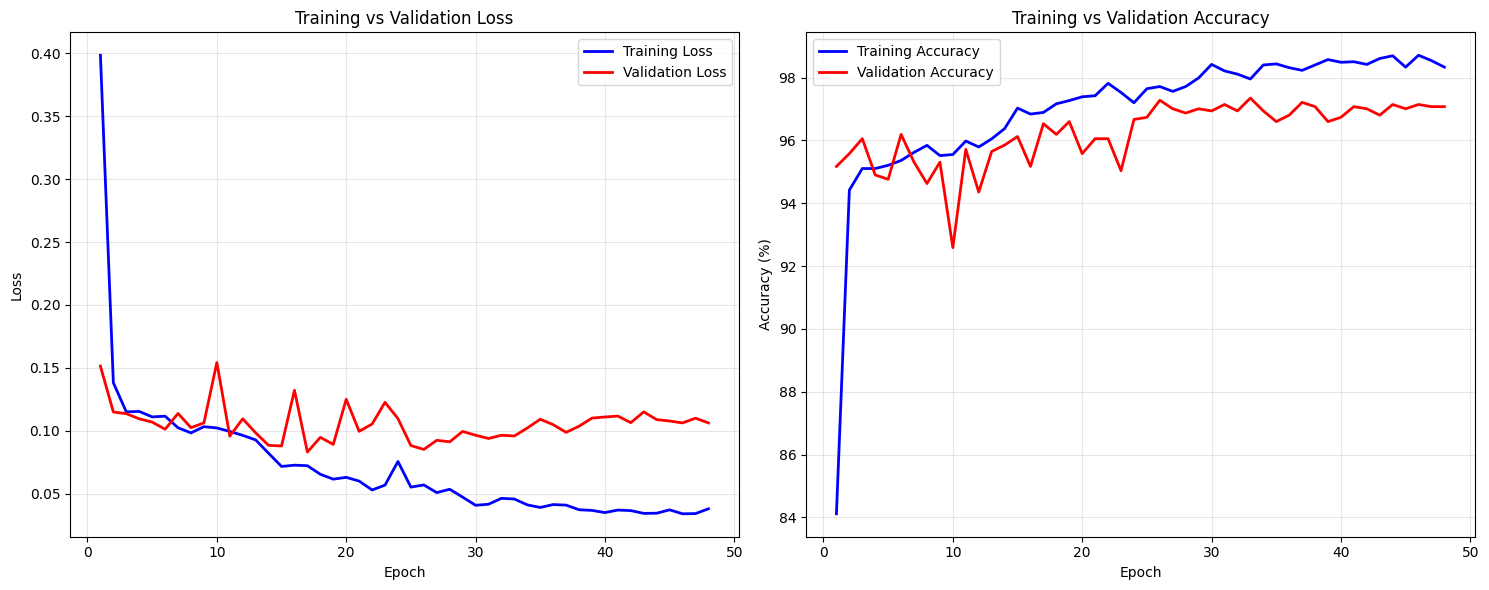


Detailed evaluation on test set:

Classification Report:
                    precision    recall  f1-score   support

           WALKING     0.9795    0.9617    0.9705       496
  WALKING_UPSTAIRS     0.9911    0.9427    0.9663       471
WALKING_DOWNSTAIRS     0.9130    1.0000    0.9545       420
           SITTING     0.9646    0.7780    0.8613       491
          STANDING     0.8304    0.9662    0.8931       532
            LAYING     1.0000    1.0000    1.0000       537

          accuracy                         0.9413      2947
         macro avg     0.9464    0.9414    0.9410      2947
      weighted avg     0.9462    0.9413    0.9408      2947



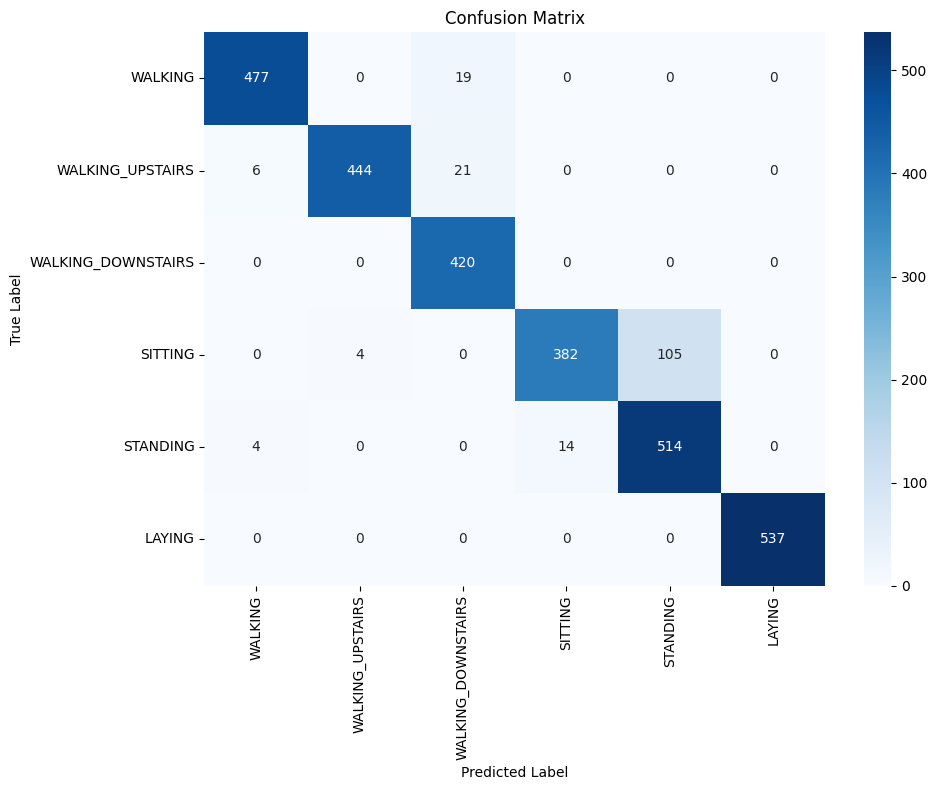

Final test accuracy: 94.1296%
Test loss: 0.3372
Training completed successfully!


In [183]:
print("STEP 4: Final evaluation...")
try:
    # Load best model
    if os.path.exists('best_model.pth'):
        model.load_state_dict(torch.load('best_model.pth'))
        print("Loaded best model weights")

    # Plot training curves
    plot_training_curves(train_losses, train_accs, val_losses, val_accs)

    # Final test set prediction
    test_acc, test_loss = evaluate_model_with_loss(model, test_loader, device)

    # Detailed evaluation on test set
    print("\nDetailed evaluation on test set:")
    accuracy, report, cm = detailed_evaluation(model, test_loader, device)

    print(f"Final test accuracy: {accuracy*100:.4f}%")
    print(f"Test loss: {test_loss:.4f}")
    print("Training completed successfully!")

except Exception as e:
    print(f"Error during evaluation: {e}")
    import traceback
    traceback.print_exc()